## Notebook for Visualization of georeferenced static data projected on map


In [1]:
%matplotlib inline
# Import libraries for geomatics
import geopandas as gp

# Import libraries for data handling
import pandas as pd
import numpy as np

In [2]:
# Convenience functions to save figure
def save_fig(fig, directory, name):
    '''save a high res and a low res version of the figure in the specified
    directory, using the label i.
    
    Parameters
    ----------
    fig : a Figure instance
    dir : str
          the directory where figures are to be saved
    name : str
    
    '''
    plt.savefig('{}/{}_low_res.png'.format(directory, name), dpi=75, 
                                             bbox_inches='tight')
    plt.savefig('{}/{}_hig_res.png'.format(directory, name), dpi=300, 
                                              bbox_inches='tight')   

In [3]:
gdf_map_elements = pd.read_pickle('preprocessing_results/pickle_obj/gdf_map_elements.pkl')
dict_mapindex_mpl_polygon = gdf_map_elements ['mpl_polygon'].to_dict()

In [5]:
# Import libraries for visualization
from matplotlib import cm
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon as mpl_Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import matplotlib as mpl
from matplotlib.colors import Normalize

import seaborn as sns
sns.set_style('white')
sns.set_palette('deep')
plt.rcParams['figure.figsize'] = 20, 8

## 2. Visualization of raw raster datasets and spatial aggregation for model
#### 2.1 Dataset on Zika environmental suitability was obtained from Messina, J. P. et al. (2016). Mapping global environmental suitability for Zika virus. eLife 5, e15272. https://elifesciences.org/content/5/e15272
![alt text](raw_data/rasterdatasets/Environmental_suitability_rasterdataset_Messina 2016/Env_suitability_raster_data.png "Title")

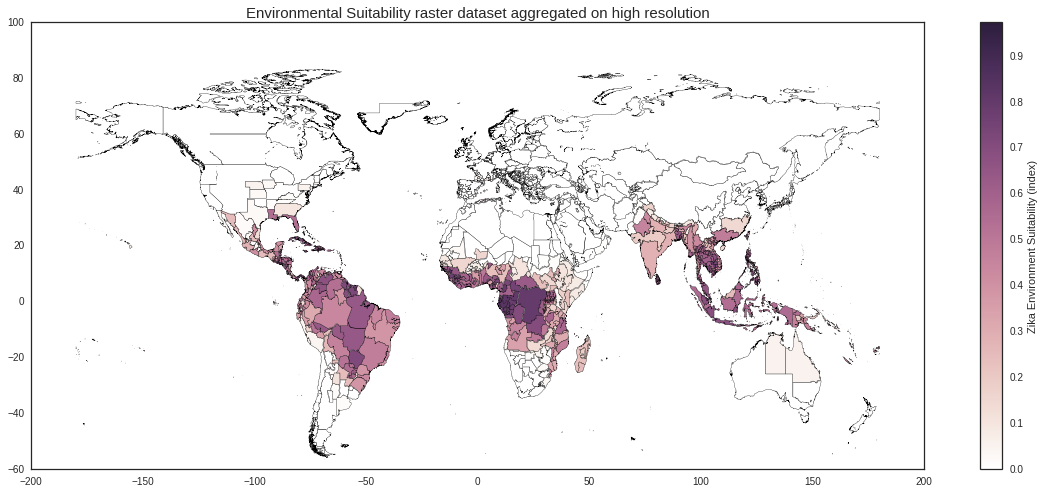

In [6]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots()
for c_l ,patches in dict_mapindex_mpl_polygon.items():
    color = gdf_map_elements .loc[c_l, 'Messinamea']
    p = PatchCollection(patches,color=cmap(color),lw=.3,edgecolor='k')
    ax.add_collection(p)
ax.autoscale_view()

p.set(array=gdf_map_elements ['Messinamea'].values, cmap=cmap)
fig.colorbar(p, label="Zika Environment Suitability (index)")

ax.set_title('Environmental Suitability raster dataset aggregated on high resolution', fontsize=15)
ax.set_ylim([-60, 100])
fig = mpl.pyplot.gcf()
save_fig(fig, './figs/', 'Env_suitability_July')
plt.show()

## 2.2 Global poverty map

#### Obtained from Elvidge, C. D., Sutton, P. C., Ghosh, T., Tuttle, B. T., Baugh, K. E., Bhaduri, B., & Bright, E. (2009). A global poverty map derived from satellite data. Computers & Geosciences, 35(8), 1652–1660. http://doi.org/10.1016/j.cageo.2009.01.009

![alt text](raw_data/rasterdatasets/A global povery map derived from satellite data_Elvidge_2008/poverty_raster_data.png "Title")


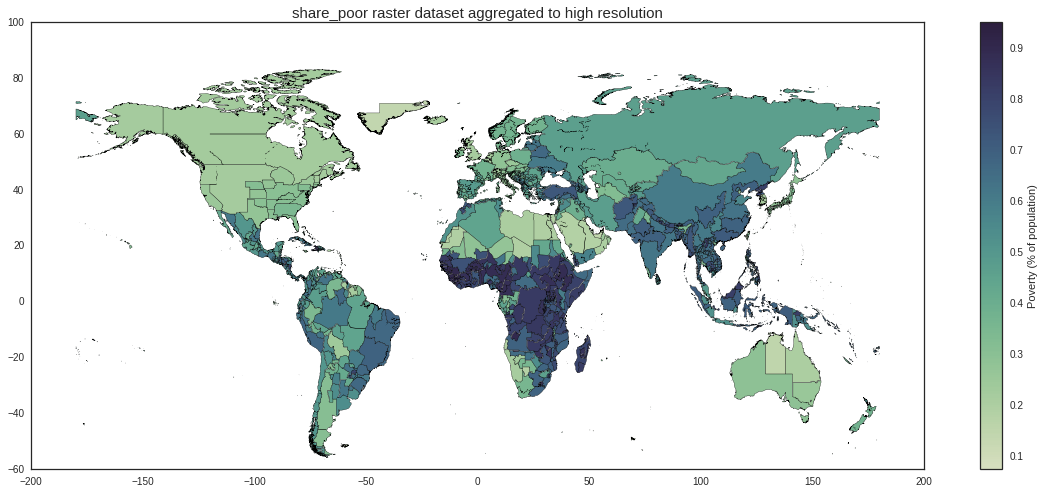

In [7]:
gdf_map_elements ['share_poor_normalized'] = gdf_map_elements ['perc_pover']
gdf_map_elements ['share_poor_normalized'] /= 100
cmap = sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True)

fig, ax = plt.subplots()
for c_l ,patches in dict_mapindex_mpl_polygon.items():
    color = gdf_map_elements .loc[c_l, 'share_poor_normalized']
    p = PatchCollection(patches,color=cmap(color),lw=.3,edgecolor='k')
    ax.add_collection(p)
ax.autoscale_view()

p.set(array=gdf_map_elements ['share_poor_normalized'].values, cmap=cmap)
ax.set_title('share_poor raster dataset aggregated to high resolution', fontsize=15)
fig.colorbar(p, label="Poverty (% of population)")
gdf_map_elements.drop('share_poor_normalized', axis=1, inplace=True)
fig = mpl.pyplot.gcf()
save_fig(fig, './figs/', 'share_poor_aggregated_low_Res')
plt.show()

In [20]:
from IPython.display import HTML
HTML('<iframe width="100%" height="520" frameborder="0" src="https://philippschw.carto.com/viz/5fa2965a-90d5-11e6-9bac-0e3a376473ab/embed_map" allowfullscreen webkitallowfullscreen mozallowfullscreen oallowfullscreen msallowfullscreen></iframe>')

#### 2.3 The population data was obtained from the most recent Gridded Population of the World, Version 4 (GPWv4), released by the Center for International Earth Science Information Network (CIESIN, 2014).

![alt text](raw_data/rasterdatasets/Gridded Population of the World GPWv4/population_raster_data.png "Title")

                Fisher_Jenks               
 
 Lower            Upper               Count
          x[i] <=  31.476               723
 31.476 < x[i] <= 102.961                29
102.961 < x[i] <= 194.584                 6
194.584 < x[i] <= 290.017                 4
290.017 < x[i] <= 750.329                 1


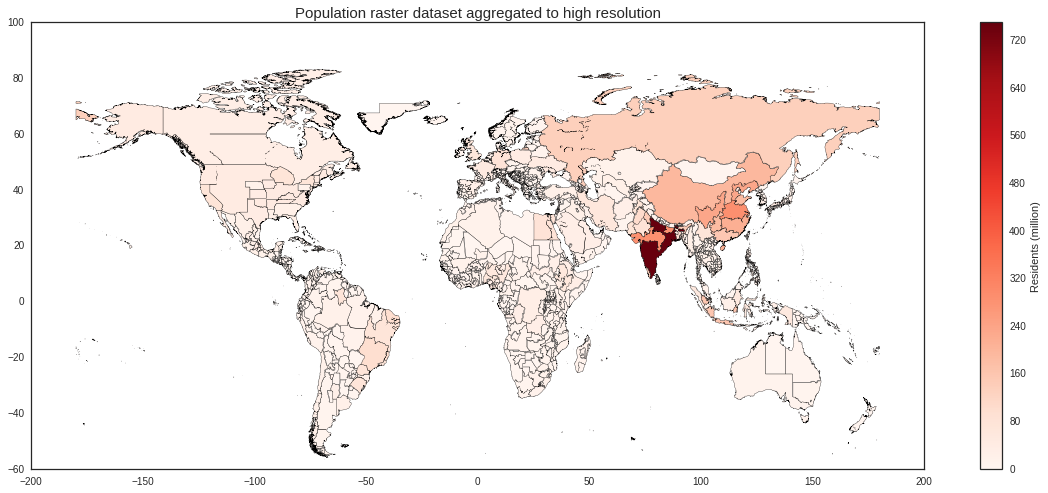

In [8]:
#### High dispersion of data requires
# normalization and utilizing pysal module of classification schemes for choropleth mapping.

# Normalization of data to in million
gdf_map_elements ['population_normalized'] = gdf_map_elements ['population']
gdf_map_elements ['population_normalized'] /= 1000000
values = gdf_map_elements ['population_normalized']

# Use Fisher Jenks optimal classifier - mean based
# based on https://github.com/geopandas/geopandas/blob/master/geopandas/plotting.py
from pysal.esda.mapclassify import Quantiles, Equal_Interval, Fisher_Jenks

schemes = {}
schemes['equal_interval'] = Equal_Interval
schemes['quantiles'] = Quantiles
schemes['fisher_jenks'] = Fisher_Jenks
scheme = 'fisher_jenks'
k = 5

s0 = scheme
scheme = scheme.lower()
if scheme not in schemes:
    scheme = 'quantiles'
binning = schemes[scheme](values, k)
print binning

def norm_cmap(values, cmap, normalize, cm):
    norm = normalize(vmin=min(values), vmax=max(values))
    n_cmap = cm.ScalarMappable(norm=norm, cmap=cmap)
    return n_cmap

binedges = [binning.yb.min()] + binning.bins.tolist()
cmap = 'Reds'
cmap = norm_cmap(values, cmap, Normalize, cm)  

fig, ax = plt.subplots()
for c_l ,patches in dict_mapindex_mpl_polygon.items():
    color = gdf_map_elements .loc[c_l, 'population_normalized']
    p = PatchCollection(patches,color=cmap.to_rgba(color),lw=.3,edgecolor='k')
    ax.add_collection(p)
ax.autoscale_view()
cmap.set_array([])
plt.colorbar(cmap, label="Residents (million)")
ax.set_title('Population raster dataset aggregated to high resolution', fontsize=15)
gdf_map_elements.drop('population_normalized', axis=1, inplace=True)
fig = mpl.pyplot.gcf()
save_fig(fig, './figs/', 'population_aggregated_low_Res')
plt.show()

#### For Verification: Plot countries and continents on worldmap

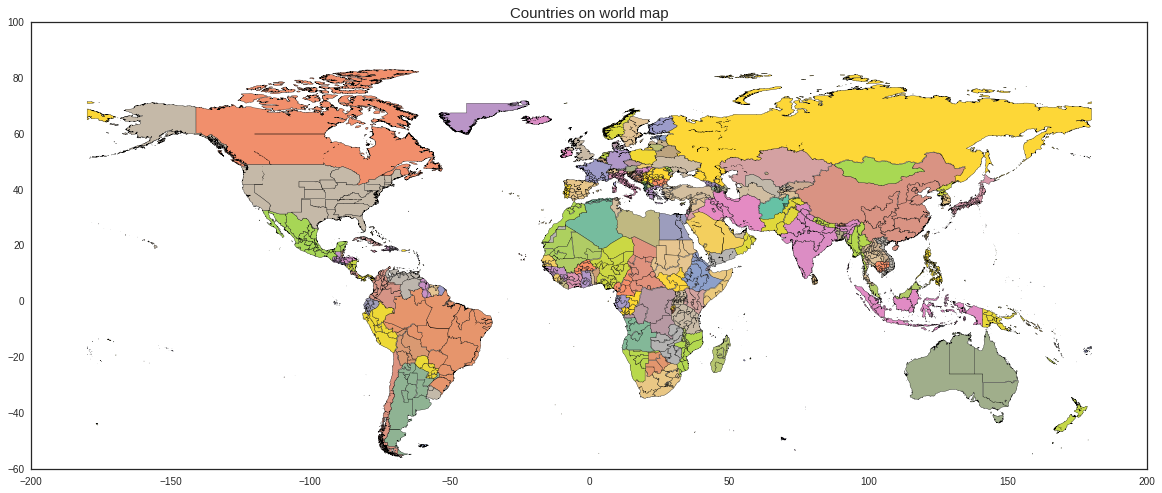

In [9]:
# In contrast to continous varibales categories(countries) have to be associated with a dict structure to colors
categories = np.unique(gdf_map_elements ['country'])
colors = np.linspace(0, 1, len(categories))
colordict = dict(zip(categories, colors))

gdf_map_elements ["countrycolor"] = gdf_map_elements ['country'].apply(lambda x: colordict[x])

fig, ax = plt.subplots()
for c_l ,patches in dict_mapindex_mpl_polygon.items():
    color = gdf_map_elements .loc[c_l, 'countrycolor']
    p = PatchCollection(patches,color=cm.Set2(color),lw=.3,edgecolor='k')
    ax.add_collection(p)
ax.autoscale_view()
gdf_map_elements .drop('countrycolor', axis=1, inplace=True)
ax.set_title('Countries on world map', fontsize=15)
fig = mpl.pyplot.gcf()
save_fig(fig, './figs/', 'Countries_worldmap')
plt.show()

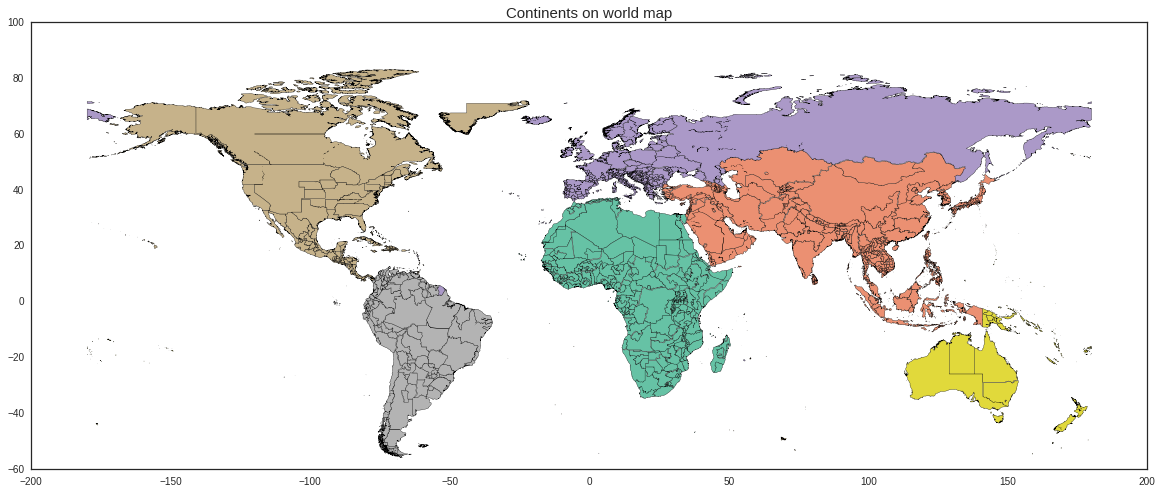

In [12]:
# In contrast to continous varibales categories(countries) have to be associated with a dict structure to colors
categories = np.unique(gdf_map_elements ['continent'])
colors = np.linspace(0, 1, len(categories))
colordict = dict(zip(categories, colors))

gdf_map_elements ["continentcolor"] = gdf_map_elements ['continent'].apply(lambda x: colordict[x])

fig, ax = plt.subplots()
for c_l ,patches in dict_mapindex_mpl_polygon.items():
    color = gdf_map_elements .loc[c_l, 'continentcolor']
    p = PatchCollection(patches,color=cm.Set2(color),lw=.3,edgecolor='k')
    ax.add_collection(p)
ax.autoscale_view()
gdf_map_elements .drop('continentcolor', axis=1, inplace=True)
ax.set_title('Continents on world map', fontsize=15)
fig = mpl.pyplot.gcf()
save_fig(fig, './figs/', 'Continents_worldmap')
plt.show()